In [19]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np
import matplotlib.pyplot as plt
import csv
import matplotlib.gridspec as gridspec
from BSE import Exchange

from BSE import market_session
from BSE import populate_market
from BSE import customer_orders


In [20]:
# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [21]:
# Define time parameters
end_time = 60 * 2  # 2 minutes simulation time

quantity = 2
# Define trader specifications

In [22]:
# Define order schedule
order_schedule = {
    'sup': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'dem': [{'from': 0.0, 'to': end_time, 'ranges': [(50, 150)], 'stepmode': 'random'}],
    'timemode': 'drip-poisson',
    'interval': 0.1,
}

In [23]:
class Trader:
    def __init__(self, ttype, tid, balance, params, time):
        self.ttype = ttype
        self.tid = tid
        self.balance = balance
        self.initial_balance = balance  # Store starting balance
        self.orders = []
        self.blotter = []
        self.n_trades = 0

    def bookkeep(self, trade, order, verbose, time):
        transaction_price = trade['price']
        if order.otype == 'Bid':  # Buying
            profit = order.price - transaction_price
        else:  # Selling
            profit = transaction_price - order.price

        self.balance += profit  # Update balance
        self.n_trades += 1

        # No longer print profit during the simulation, only store it for final output
        # if verbose:
        #     print(f"{self.tid}: Profit={profit}, Balance={self.balance}")


# === Modify the Run Multiple Market Sessions ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs only the final profit at the end."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        time += timestep

    # After the simulation ends, log the final profit for each trader
    write_final_trade_stats(sess_id, traders, tdump)


# === Function to Log Final Trader Statistics in CSV ===
def write_final_trade_stats(expid, traders, tdump):
    """Log the final profit of each trader after the session ends."""
    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        final_profit = trader.balance - trader.initial_balance  # Final profit at the end of the session

        # Write the final results to CSV
        tdump.write(f"{expid},{ttype},{final_profit}\n")


In [24]:
from itertools import combinations

# === Modify the Run Multiple Market Sessions ===
def market_session_with_logging(sess_id, starttime, endtime, traders_spec, order_schedule, dump_flags, verbose, tdump):
    """Runs a market session and logs the profit for each trader at the end."""
    exchange = Exchange()
    traders = {}
    trader_stats = populate_market(traders_spec, traders, shuffle=True, verbose=verbose)

    timestep = 1.0 / (trader_stats['n_buyers'] + trader_stats['n_sellers'])
    time = starttime
    pending_cust_orders = []

    while time < endtime:
        time_left = (endtime - time) / (endtime - starttime)

        # Process customer orders
        pending_cust_orders, kills = customer_orders(
            time=time, last_update=-1, traders=traders, trader_stats=trader_stats,
            os=order_schedule, pending=pending_cust_orders, verbose=verbose
        )

        # Handle order cancellations
        for kill in kills:
            if traders[kill].lastquote is not None:
                exchange.del_order(time, traders[kill].lastquote, verbose=verbose)

        # Get a limit-order quote from a randomly selected trader
        tid = random.choice(list(traders.keys()))
        order = traders[tid].getorder(time, time_left, exchange.publish_lob(time, None, verbose=verbose))

        if order is not None:
            trade = exchange.process_order2(time, order, verbose=verbose)
            if trade:
                traders[trade['party1']].bookkeep(trade, order, verbose=verbose, time=time)
                traders[trade['party2']].bookkeep(trade, order, verbose=verbose, time=time)

        time += timestep

    # After the simulation ends, log the profit for each trader type separately
    write_final_trade_stats(sess_id, traders, tdump)


# === Function to Log Trader Statistics in CSV ===
def write_final_trade_stats(expid, traders, tdump):
    """Log the profit of each trader type (separately) after the session ends."""
    profit_by_type = {'MarketMaker': 0, 'ZIC': 0, 'ZIP': 0, 'GVWY': 0, 'SHVR': 0, 'SNPR': 0}  # Adding ZIP for completeness

    # Calculate profit for each trader based on their type
    for t in traders:
        trader = traders[t]
        ttype = trader.ttype
        profit = trader.balance - trader.initial_balance  # Profit for this trader
        if ttype in profit_by_type:
            profit_by_type[ttype] += profit  # Sum the profit for each trader type

    # Write separate lines for each trader type (MarketMaker, ZIC, ZIP, etc.)
    for trader_type, profit in profit_by_type.items():
        if profit != 0:  # Only write results if the profit is non-zero
            tdump.write(f"{expid},{trader_type},{profit}\n")



# === Main Block for Running Multiple Market Sessions ===
output_file = 'bigtestdata4.csv'
with open(output_file, 'w') as tdump:
    tdump.write("Trial,TraderTypes,TotalProfit\n")

    max_trials = 1000  # 5 simulations for each combination
    trial_id = 1

    combinations = [
        ('ZIC', 'MarketMaker'),  # Run ZIC vs MarketMaker
        ('ZIP', 'MarketMaker'),  # Run ZIP vs MarketMaker
        ('GVWY', 'MarketMaker'),  # Run GVWY vs MarketMaker
        ('SHVR', 'MarketMaker'),
        ('SNPR', 'MarketMaker')
    ]

    for combo in combinations:
        print(f"Running combination: {combo[0]} vs {combo[1]}")
        
        for trial in range(max_trials):  # Run 5 simulations for each combination
            # Define the trader specification for each combination
            traders_spec = {
                'buyers': [(combo[0], quantity), (combo[1], quantity)],
                'sellers': [(combo[0], quantity), (combo[1], quantity)],
            }

            # Log the progress for each trial
            print(f"Running {combo[0]} vs {combo[1]} (Trial {trial_id}/{len(combinations) * max_trials})...")

            # Run the market session and log separate profits for each trader type
            market_session_with_logging(
                f'trial{trial_id:04d}', 0.0, end_time, traders_spec, order_schedule,
                {
                    'dump_tape': False, 'dump_strats': False,
                    'dump_lobs': False, 'dump_blotters': False,
                    'dump_avgbals': False,
                },
                verbose=False, tdump=tdump
            )

            # Increment trial_id after logging for each combination
            trial_id += 1

    print(f"Completed {len(combinations) * max_trials} trials. Results saved to {output_file}.")





Running combination: ZIC vs MarketMaker
Running ZIC vs MarketMaker (Trial 1/5000)...
Running ZIC vs MarketMaker (Trial 2/5000)...
Running ZIC vs MarketMaker (Trial 3/5000)...
Running ZIC vs MarketMaker (Trial 4/5000)...
Running ZIC vs MarketMaker (Trial 5/5000)...
Running ZIC vs MarketMaker (Trial 6/5000)...
Running ZIC vs MarketMaker (Trial 7/5000)...
Running ZIC vs MarketMaker (Trial 8/5000)...
Running ZIC vs MarketMaker (Trial 9/5000)...
Running ZIC vs MarketMaker (Trial 10/5000)...
Running ZIC vs MarketMaker (Trial 11/5000)...
Running ZIC vs MarketMaker (Trial 12/5000)...
Running ZIC vs MarketMaker (Trial 13/5000)...
Running ZIC vs MarketMaker (Trial 14/5000)...
Running ZIC vs MarketMaker (Trial 15/5000)...
Running ZIC vs MarketMaker (Trial 16/5000)...
Running ZIC vs MarketMaker (Trial 17/5000)...
Running ZIC vs MarketMaker (Trial 18/5000)...
Running ZIC vs MarketMaker (Trial 19/5000)...
Running ZIC vs MarketMaker (Trial 20/5000)...
Running ZIC vs MarketMaker (Trial 21/5000)...
Run

In [25]:
print(quantity)

2


In [26]:
df = pd.read_csv('bigtestdata4.csv')
df['TotalProfit'] = df['TotalProfit'] / quantity
df.head(20)

,Trial,TraderTypes,TotalProfit
0,trial0001,MarketMaker,1364.5
1,trial0001,ZIC,544.0
2,trial0002,MarketMaker,1559.5
3,trial0002,ZIC,652.0
4,trial0003,MarketMaker,1561.0
5,trial0003,ZIC,435.5
6,trial0004,MarketMaker,1563.5
7,trial0004,ZIC,421.0
8,trial0005,MarketMaker,1105.5
9,trial0005,ZIC,442.5


In [27]:
# Count how many unique TraderTypes each trial has
df["TraderTypeCount"] = df.groupby("Trial")["TraderTypes"].transform("nunique")

In [28]:
# Count how many unique TraderTypes each trial has
df["TraderTypeCount"] = df.groupby("Trial")["TraderTypes"].transform("nunique")

# Keep only trials that have exactly 2 unique TraderTypes
df = df[df["TraderTypeCount"] == 2]

# Now create your Combination column
df["Combination"] = df.groupby("Trial")["TraderTypes"].transform(lambda x: " vs ".join(sorted(x.unique())))

In [29]:
df.head(20)

,Trial,TraderTypes,TotalProfit,TraderTypeCount,Combination
0,trial0001,MarketMaker,1364.5,2,MarketMaker vs ZIC
1,trial0001,ZIC,544.0,2,MarketMaker vs ZIC
2,trial0002,MarketMaker,1559.5,2,MarketMaker vs ZIC
3,trial0002,ZIC,652.0,2,MarketMaker vs ZIC
4,trial0003,MarketMaker,1561.0,2,MarketMaker vs ZIC
5,trial0003,ZIC,435.5,2,MarketMaker vs ZIC
6,trial0004,MarketMaker,1563.5,2,MarketMaker vs ZIC
7,trial0004,ZIC,421.0,2,MarketMaker vs ZIC
8,trial0005,MarketMaker,1105.5,2,MarketMaker vs ZIC
9,trial0005,ZIC,442.5,2,MarketMaker vs ZIC


In [30]:
# Create a Combination column based on pairs of TraderTypes for each trial
df['Combination'] = df.groupby('Trial')['TraderTypes'].transform(lambda x: ' vs '.join(sorted(x.unique())))

# Max trials per combination

# Initialize an empty list to store results
stats_per_combination = []

# Process each combination separately
combinations = df['Combination'].unique()  # Get unique combinations
for combo in combinations:
    print(f"Processing Combination: {combo}")

    # Filter the data for this combination
    filtered_df = df[df['Combination'] == combo]

    # Calculate the aggregated statistics for this combination
    aggregated_stats = filtered_df.groupby(['Combination', 'TraderTypes'])['TotalProfit'].agg(['mean', 'std', 'var']).reset_index()

    # Store the statistics in the list
    stats_per_combination.append(aggregated_stats)

# Combine all results into a single DataFrame
final_stats_df = pd.concat(stats_per_combination, ignore_index=True)



# Display the first few rows of the DataFrame
final_stats_df.head(20)

Processing Combination: MarketMaker vs ZIC
Processing Combination: MarketMaker vs ZIP
Processing Combination: GVWY vs MarketMaker
Processing Combination: MarketMaker vs SHVR
Processing Combination: MarketMaker vs SNPR


,Combination,TraderTypes,mean,std,var
0,MarketMaker vs ZIC,MarketMaker,1397.3410,213.484962,45575.829048
1,MarketMaker vs ZIC,ZIC,442.1895,127.924834,16364.763103
2,MarketMaker vs ZIP,MarketMaker,1527.8520,221.955866,49264.406503
3,MarketMaker vs ZIP,ZIP,1618.7220,236.779773,56064.660877
4,GVWY vs MarketMaker,GVWY,1727.6090,231.713560,53691.173793
5,GVWY vs MarketMaker,MarketMaker,1680.9250,240.830227,57999.198073
6,MarketMaker vs SHVR,MarketMaker,1513.7200,185.804739,34523.401001
7,MarketMaker vs SHVR,SHVR,620.4805,161.392481,26047.532903
8,MarketMaker vs SNPR,MarketMaker,1424.2120,204.403575,41780.821377
9,MarketMaker vs SNPR,SNPR,163.0520,78.905357,6226.055351


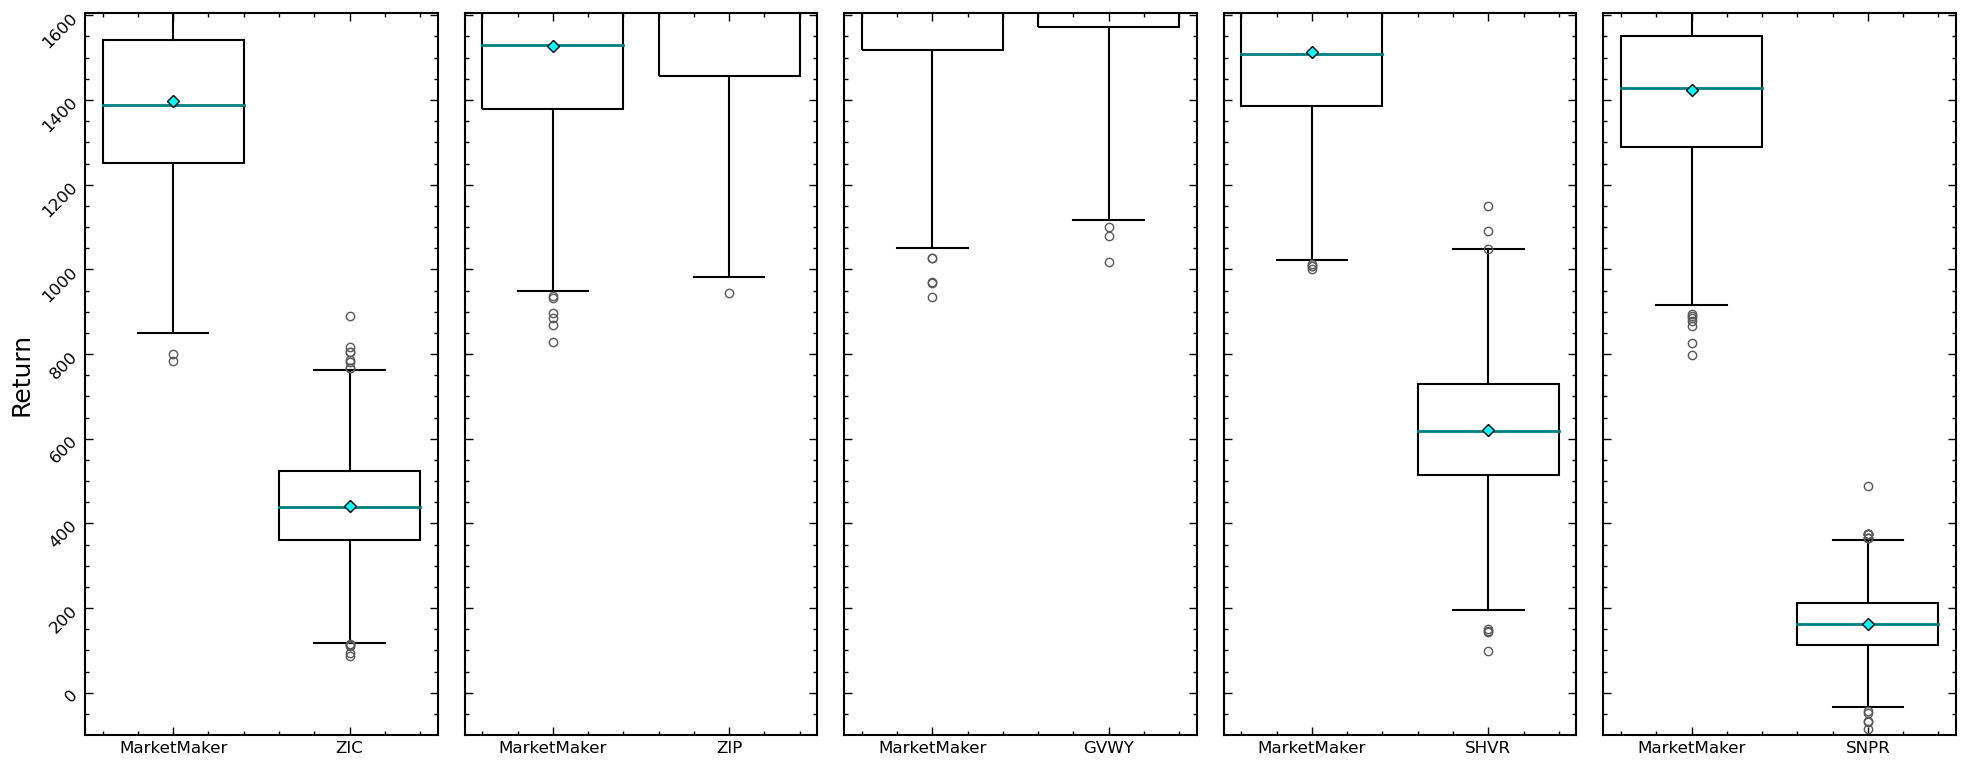

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains 'TotalProfit' and 'TraderTypes' and final_stats_df contains the aggregated statistics

# Merge df and final_stats_df on 'TraderTypes' and 'Combination' to get all necessary columns
merged_df = pd.merge(df, final_stats_df[['Combination', 'TraderTypes', 'mean', 'std', 'var']], 
                     on=['Combination', 'TraderTypes'], how='left')

# Get unique combinations for plotting
combinations = merged_df['Combination'].unique()
n_combinations = len(combinations)

# Set up the subplots
fig, axes = plt.subplots(1, n_combinations, figsize=(20, 8))

# If there is only one combination, axes is not a list, so handle this case
if n_combinations == 1:
    axes = [axes]

# Loop through each combination and plot on the corresponding subplot
for i, combo in enumerate(combinations):
    # Filter data for the current combination
    combo_data = merged_df[merged_df['Combination'] == combo]
    
    # Create the boxplot for this combination
    sns.boxplot(
        x='TraderTypes', 
        y='TotalProfit', 
        data=combo_data,
        showmeans=True,
        palette="Set2",
        ax=axes[i],  # Assign to the correct subplot
        boxprops={
            "facecolor": "none",     # no fill
            "edgecolor": "black",    # box outline color
            "linewidth": 1.5
        },
        whiskerprops={"color":"black","linewidth":1.5},
        capprops={"color":"black","linewidth":1.5},
        medianprops={"color":"teal","linewidth":2},
        flierprops={
            "marker":"o",
            "markerfacecolor":"none",
            "markersize":6,
            "linestyle":"none"
        },
        meanprops={
            "marker":"D",
            "markerfacecolor":"cyan",
            "markeredgecolor":"black",
            "markersize":6
        }
    )

    # Set labels and title for each plot
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='y', rotation=45)
    axes[i].set_ylim(-100,1605)

    axes[0].set_ylabel('Return')

    # For the first subplot, set the y-axis label and ticks
    if i == 0:
        axes[i].set_ylabel('Return')
    else:
        # Hide the y-ticks and y-labels for other subplots
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([])

    axes[i].minorticks_on() # Enable minor ticks for the first subplot
    axes[i].tick_params(axis='both', which='major', direction='in', length=6, width=1, labelsize=12,
                    top=True, bottom=True, left=True, right=True)
    axes[i].tick_params(axis='both', which='minor', direction='in', length=3, width=1,
                    top=True, bottom=True, left=True, right=True)
    

    # Apply thicker border edges to both subplots
    for ax in axes:
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)  # Adjust thickness (2 is thicker, increase if needed)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

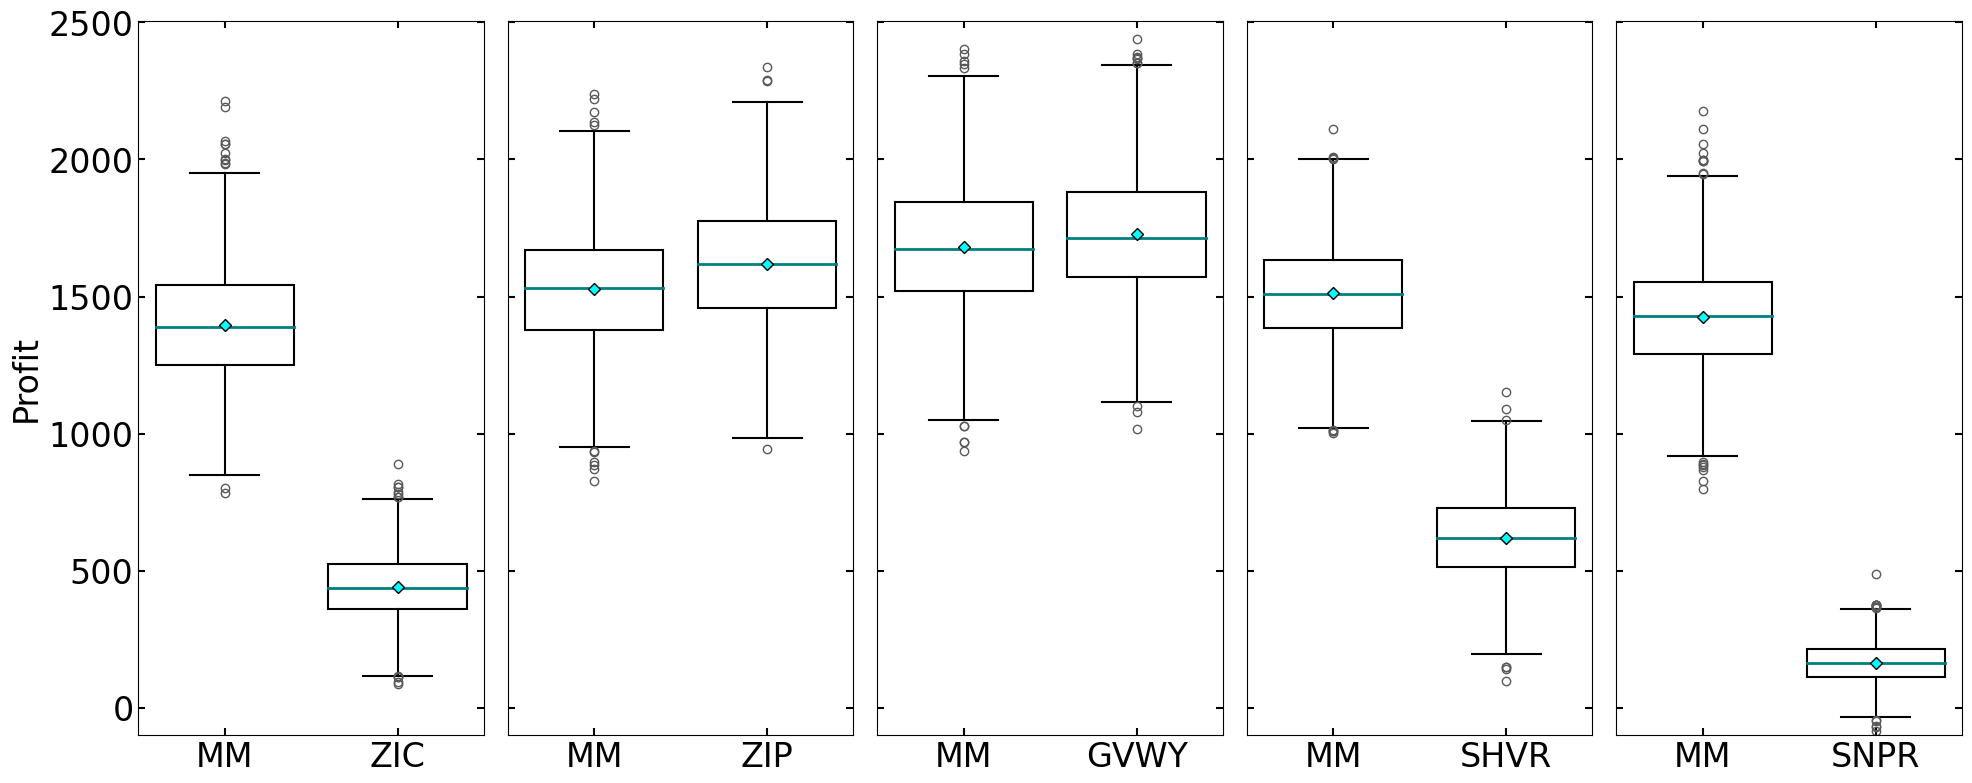

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df contains 'TotalProfit' and 'TraderTypes' and final_stats_df contains the aggregated statistics

# Merge df and final_stats_df on 'TraderTypes' and 'Combination' to get all necessary columns
merged_df = pd.merge(df, final_stats_df[['Combination', 'TraderTypes', 'mean', 'std', 'var']], 
                     on=['Combination', 'TraderTypes'], how='left')

# right after you build/merge your df, do:
merged_df['TraderTypes'] = merged_df['TraderTypes'].replace({'MarketMaker':'MM'})

# then the rest of your plotting code stays exactly the same,
# and seaborn will automatically draw “MM” instead of “MarketMaker”

# Get unique combinations for plotting
combinations = merged_df['Combination'].unique()
n_combinations = len(combinations)

# Set up the subplots
fig, axes = plt.subplots(1, n_combinations, figsize=(20, 8))

# If there is only one combination, axes is not a list, so handle this case
if n_combinations == 1:
    axes = [axes]

# Loop through each combination and plot on the corresponding subplot
for i, combo in enumerate(combinations):
    # Filter data for the current combination
    combo_data = merged_df[merged_df['Combination'] == combo]
    
    # Create the boxplot for this combination
    sns.boxplot(
        x='TraderTypes', 
        y='TotalProfit', 
        data=combo_data,
        showmeans=True,
        palette="Set2",
        ax=axes[i],  # Assign to the correct subplot
        boxprops={
            "facecolor": "none",     # no fill
            "edgecolor": "black",    # box outline color
            "linewidth": 1.5
        },
        whiskerprops={"color":"black","linewidth":1.5},
        capprops={"color":"black","linewidth":1.5},
        medianprops={"color":"teal","linewidth":2},
        flierprops={
            "marker":"o",
            "markerfacecolor":"none",
            "markersize":6,
            "linestyle":"none"
        },
        meanprops={
            "marker":"D",
            "markerfacecolor":"cyan",
            "markeredgecolor":"black",
            "markersize":6
        }
    )

    # Set labels and title for each plot
    axes[i].set_xlabel('')


    # For the first subplot, set the y-axis label and ticks
    if i == 0:
        axes[i].set_ylabel('Profit', fontsize =24)
        axes[i].tick_params(axis='x', which='major', direction='in', length=5, width=1.5, labelsize=24,
                    top=True, bottom=True, left=False, right=True)
        axes[i].tick_params(axis='y', which='major', direction='in', length=5, width=1.5, labelsize=24,
                    top=False, bottom=False, left=True, right=True)
       
    else:
        # Hide the y-ticks and y-labels for other subplots
        axes[i].set_ylabel('')
        axes[i].minorticks_off()
        axes[i].tick_params(axis='y', rotation=45)
        axes[i].set_yticklabels([])
        axes[i].tick_params(axis='x', which='major', direction='in', length=5, width=1.5, labelsize=24,
                    top=True, bottom=True, left=False, right=True)
        axes[i].tick_params(axis='y', which='major', direction='in', length=5, width=1.5, labelsize=24,
                    top=False, bottom=False, left=True, right=True)
        


# Adjust layout for better spacing
plt.tight_layout()

for ax in axes:
    ax.set_ylim(-100, 2505)


plt.show()